# Chest X-Ray Pneumonia Classification

## 1. Importing Necessary Libraries

In [1]:
# utilities
import numpy as np # linear algebra
import pandas as pd # data processing
import pickle
import random

# visualization
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# tensorflow
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("../input"))

['chest-xray-pneumonia']


## 2. Preprocessing


### Function that reads the images to numpy arrays

In [2]:
def img_to_array(path, category_no, X, y):
    for p in os.listdir(path):
        if p == ".DS_Store":
            continue
        #print(p)
        img = cv2.imread(os.path.join(path, p), cv2.IMREAD_GRAYSCALE)
        img_np = cv2.resize(img, dsize = (150, 150))
        X.append(img_np)
        y.append(category_no)

### Reading train images

In [ ]:
path_train = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/"

category_list = ["NORMAL", "PNEUMONIA"]

X_train = []
y_train = []

for i in range(len(category_list)):
    img_to_array(path_train + category_list[i], i, X_train, y_train)
    
X_train = np.array(X_train).reshape(-1,150,150,1)
y_train = np.array(y_train)

### Reading validation images

In [ ]:
path_val = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/"

X_val = []
y_val = []

for i in range(len(category_list)):
    img_to_array(path_val + category_list[i], i, X_val, y_val)
    
X_val = np.array(X_val).reshape(-1,150,150,1)
y_val = np.array(y_val)

### Reading test images

In [5]:
path_test = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/"


X_test = []
y_test = []

for i in range(len(category_list)):
    img_to_array(path_test + category_list[i], i, X_test, y_test)
    
X_test = np.array(X_test).reshape(-1,150,150,1)
y_test = np.array(y_test)

**We also reshape the X_train, X_test, X_pred arrays and y_train, y_test arrays in order to use in Convolutional Neural Network Layers.**

### Let's look at their shapes

In [6]:
X_train.shape, y_train.shape

((5216, 150, 150, 1), (5216,))

In [7]:
X_val.shape, y_val.shape

((16, 150, 150, 1), (16,))

In [8]:
X_test.shape, y_test.shape

((624, 150, 150, 1), (624,))

### Let's look at some images


#### Normal

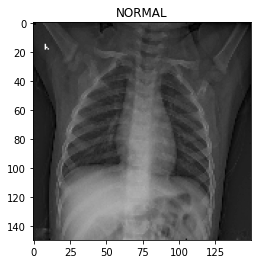

In [9]:
plt.imshow(X_train[0], cmap = "gray")
plt.title(category_list[y_train[0]]);

#### Pneumonia

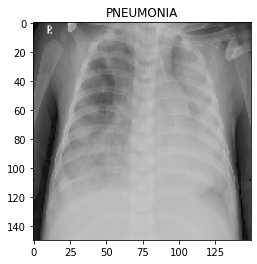

In [10]:
plt.imshow(X_train[5215], cmap = "gray")
plt.title(category_list[y_train[5215]]);

### Let's visualize the number of classes

<AxesSubplot:ylabel='count'>

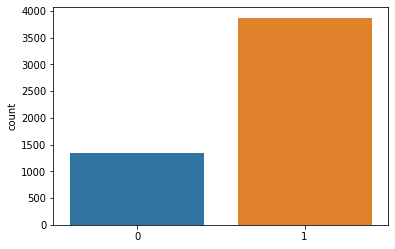

In [11]:
sns.countplot(y_train)

#### The data is imbalanced, so we should use data augmentation method.

### Normalizing

#### Here we normalize the data so it converges faster to global minima.

In [12]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

## 3. Modeling and Predicting

### Data Augmentation

#### Our data is imbalanced. To avoid this and overfitting, we perform data augmentation. The idea of data augmentation is we perform some distortions to our existing data and we get new various data. For example we apply horizontal flip, random zoom, height and width shift.

#### We apply randomly rotation 30 degrees, randomly zoom 20%, randomly shift 10%, and flipping horizontally.

In [13]:
datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip = False)  # randomly flip images


datagen.fit(X_train)

### Here we are constructing our CNN layers. We use Conv2D, MaxPooling2D, Dropout, Flatten and Dense layers.

In [14]:
model = Sequential([
    Conv2D(32, (3,3), activation = "relu", input_shape = (150,150,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation = "relu"),
    Dropout(0.1),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation = "relu"),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation = "relu"),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation = "relu"),
    Dropout(0.2),
    Dense(1, activation = "sigmoid")
])

### Here we set compiler configurations.

In [15]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

### Here we save the history of fitting the data.

In [16]:
history = model.fit(datagen.flow(X_train, y_train, batch_size = 32), epochs = 20, validation_data = datagen.flow(X_val, y_val))

Epoch 1/20
163/163 [==============================] - 18s 65ms/step - loss: 0.4554 - accuracy: 0.8386 - val_loss: 4.2526 - val_accuracy: 0.5000
Epoch 2/20
163/163 [==============================] - 11s 65ms/step - loss: 0.2214 - accuracy: 0.9124 - val_loss: 6.0201 - val_accuracy: 0.5000
Epoch 3/20
163/163 [==============================] - 10s 62ms/step - loss: 0.2003 - accuracy: 0.9184 - val_loss: 5.1964 - val_accuracy: 0.5000
Epoch 4/20
163/163 [==============================] - 10s 61ms/step - loss: 0.1892 - accuracy: 0.9236 - val_loss: 0.9589 - val_accuracy: 0.6250
Epoch 5/20
163/163 [==============================] - 11s 66ms/step - loss: 0.1729 - accuracy: 0.9348 - val_loss: 3.8002 - val_accuracy: 0.5000
Epoch 6/20
163/163 [==============================] - 10s 62ms/step - loss: 0.1829 - accuracy: 0.9275 - val_loss: 1.1501 - val_accuracy: 0.5625
Epoch 7/20
163/163 [==============================] - 10s 61ms/step - loss: 0.1740 - accuracy: 0.9300 - val_loss: 5.6176 - val_accuracy:

### Let's see the accuracy.

In [17]:
_, accuracy = model.evaluate(X_test, y_test)
print("Accuracy: %.2f" % (accuracy*100))

20/20 [==============================] - 0s 7ms/step - loss: 0.2061 - accuracy: 0.9295
Accuracy: 92.95


### Let's visualize model accuracy and model loss.

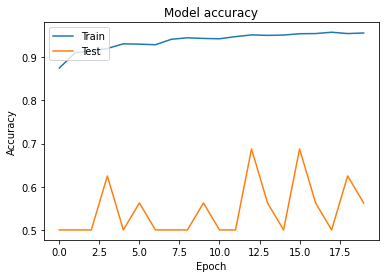

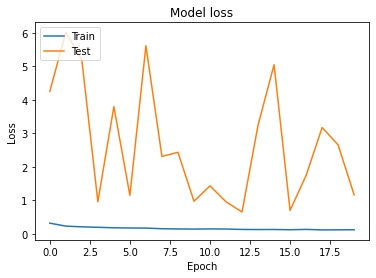

In [18]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc = "upper left")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc = "upper left")
plt.show()

### Let's see the confusion matrix.

<AxesSubplot:>

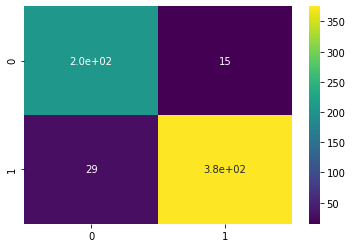

In [19]:
sns.heatmap(confusion_matrix(model.predict_classes(X_test), y_test), cmap = "viridis", annot = True)

### As we see our model predicts 85%-90% correctly.